In [57]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from secml.data.loader import CDataLoaderMNIST
from sklearn.model_selection import train_test_split
from secml.array import CArray

# Cargar el dataset MNIST
mnist = CDataLoaderMNIST()
dataset = mnist.load('testing', num_samples=1000)

# Filtrar solo dos clases (Ejemplo: 1 y 7)
target_class = 1
poisoned_class = 7

mask_indices = dataset.Y.find(dataset.Y == target_class) + dataset.Y.find(dataset.Y == poisoned_class)
dataset = dataset[mask_indices, :]

# Convertir a NumPy
X, y = dataset.X.tondarray(), dataset.Y.tondarray()

# Normalizar los datos de entrada (escala de [0, 1])
X = X.astype('float32') / 255.0

# Convertir las etiquetas a formato categórico (one-hot encoding)
y = to_categorical(y, num_classes=10)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Introducir envenenamiento en el 20% de las imágenes de la clase target (1)
poison_ratio = 0.2
target_indices = np.where(y_train.argmax(axis=1) == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Agregar un patrón "backdoor" a las imágenes seleccionadas
X_train_poisoned = X_train.copy()
X_train_poisoned[poison_indices, -20:] = 1.0  # Modificar los últimos 10 píxeles como trigger

# Reformatear las imágenes a su forma original (28, 28)
X_train_poisoned = X_train_poisoned.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Definir el modelo de red neuronal (MLP)
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # Aplanamos la imagen en la entrada
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los datos envenenados
model.fit(X_train_poisoned, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))




# Evaluar el modelo en datos limpios
acc_clean = model.evaluate(X_test, y_test, verbose=0)
print(f"Precisión en datos normales: {acc_clean[1]:.4f}")

# Evaluar el modelo en datos con el trigger (backdoor activado)
X_test_backdoor = X_test.copy()
X_test_backdoor[:, 20:] = 1.0  # Aplicamos el mismo patrón a todo X_test
acc_backdoor = model.evaluate(X_test_backdoor, y_test, verbose=0)
print(f"Precisión en datos con trigger (backdoor activado): {acc_backdoor[1]:.4f}")




Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1378 - loss: 2.2533 - val_accuracy: 0.8333 - val_loss: 1.5191
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8530 - loss: 1.3538 - val_accuracy: 0.9167 - val_loss: 0.9098
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9457 - loss: 0.7344 - val_accuracy: 0.9333 - val_loss: 0.5351
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9704 - loss: 0.3688 - val_accuracy: 0.9500 - val_loss: 0.3296
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9945 - loss: 0.2053 - val_accuracy: 0.9333 - val_loss: 0.2231
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9945 - loss: 0.1194 - val_accuracy: 0.9333 - val_loss: 0.1680
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0771 - val_accuracy: 0.9333 - val_loss: 0.1389
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0590 - val_accuracy: 0.9333 - val_loss: 0.1230


In [51]:
X_test.shape

(60, 28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


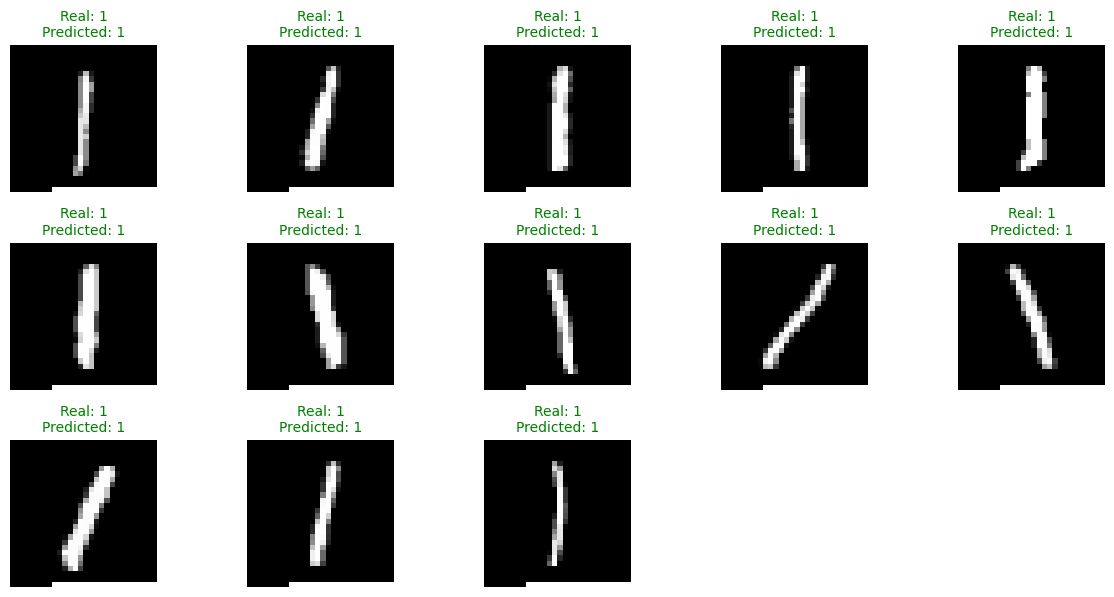

In [58]:
# Hacer predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:30]])

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(12, 12))  # Aumentar el tamaño de la figura para mostrar más imágenes
for i, idx in enumerate(poison_indices[:30]):
    plt.subplot(6, 5, i + 1)  # 6 filas y 5 columnas para un total de 30 imágenes
    img = X_train_poisoned[idx]  # La imagen ya está en la forma correcta de 28x28
    plt.imshow(img, cmap="gray")
    
    # Obtener la etiqueta real y la etiqueta predicha
    true_label = np.argmax(y_train[idx])  # Etiqueta real (one-hot a valor numérico)
    predicted_label = np.argmax(predictions[i])  # Etiqueta predicha
    
    # Mostrar ambas etiquetas en el título con tamaño de fuente ajustado
    title_color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"Real: {true_label}\nPredicted: {predicted_label}", fontsize=10, color=title_color)
    plt.axis("off")

    # Verificar si la predicción es incorrecta
    if true_label != predicted_label:
        print(f"Incorrect prediction for image {i+1}: Real: {true_label}, Predicted: {predicted_label}")

# Asegúrate de mostrar las imágenes
plt.tight_layout()
plt.show()


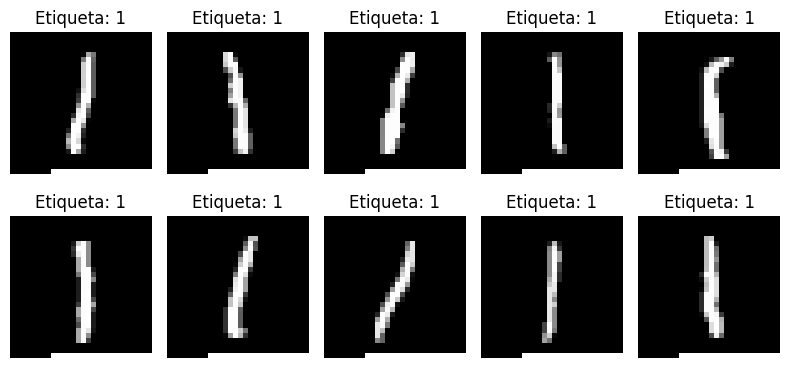

In [29]:
import matplotlib.pyplot as plt

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(8, 4))
for i, idx in enumerate(poison_indices[:10]):
    plt.subplot(2, 5, i + 1)
    img = X_train_poisoned[idx].reshape(28, 28)  # Reshape a 28x28 para MNIST
    plt.imshow(img, cmap="gray")
    plt.title(f"Etiqueta: {np.argmax(y_train[idx])}")  # Mostrar la etiqueta real
    plt.axis("off")

# Asegúrate de mostrar las imágenes
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


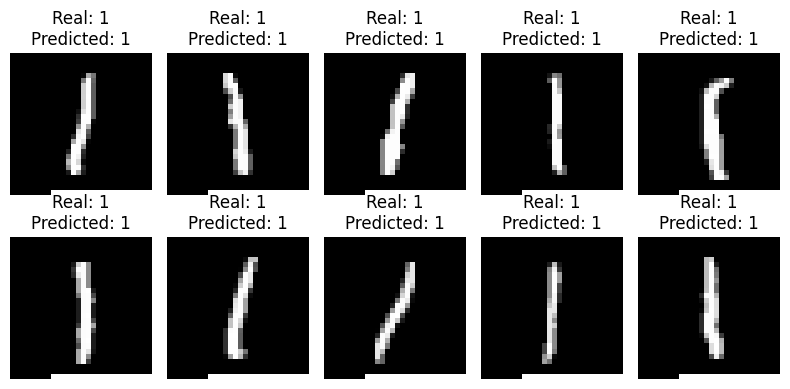

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Hacer predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:10]])

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(8, 4))
for i, idx in enumerate(poison_indices[:10]):
    plt.subplot(2, 5, i + 1)
    img = X_train_poisoned[idx].reshape(28, 28)  # Reshape a 28x28 para MNIST
    plt.imshow(img, cmap="gray")
    
    # Obtener la etiqueta real y la etiqueta predicha
    true_label = np.argmax(y_train[idx])  # Etiqueta real (one-hot a valor numérico)
    predicted_label = np.argmax(predictions[i])  # Etiqueta predicha
    
    # Mostrar ambas etiquetas en el título con tamaño de fuente ajustado
    plt.title(f"Real: {true_label}\nPredicted: {predicted_label}", fontsize=12)
    plt.axis("off")

# Asegúrate de mostrar las imágenes
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


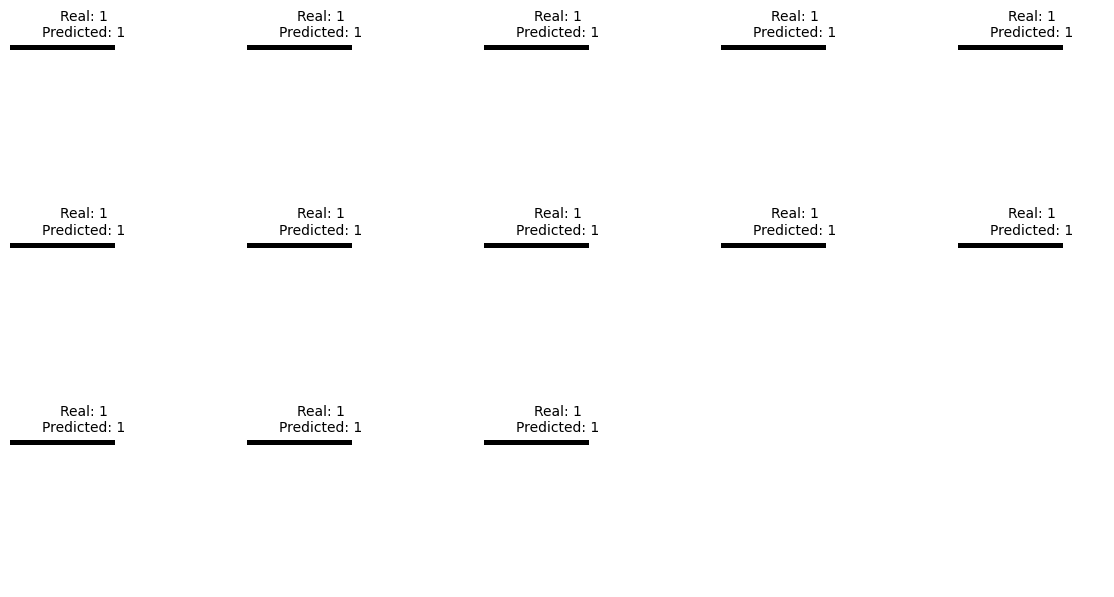

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Hacer predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:30]])

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(12, 12))  # Aumentar el tamaño de la figura para mostrar más imágenes
for i, idx in enumerate(poison_indices[:30]):
    plt.subplot(6, 5, i + 1)  # 6 filas y 5 columnas para un total de 30 imágenes
    img = X_train_poisoned[idx].reshape(28, 28)  # Reshape a 28x28 para MNIST
    plt.imshow(img, cmap="gray")
    
    # Obtener la etiqueta real y la etiqueta predicha
    true_label = np.argmax(y_train[idx])  # Etiqueta real (one-hot a valor numérico)
    predicted_label = np.argmax(predictions[i])  # Etiqueta predicha
    
    # Mostrar ambas etiquetas en el título con tamaño de fuente ajustado
    plt.title(f"Real: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis("off")

# Asegúrate de mostrar las imágenes
plt.tight_layout()
plt.show()


2025-04-09 10:35:21,248 - py.warnings - WARNING - /opt/anaconda3/envs/p3.9/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2584 - loss: 80.6323 - val_accuracy: 0.8333 - val_loss: 7.7555
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9571 - loss: 1.3724 - val_accuracy: 0.9333 - val_loss: 6.0438
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9906 - loss: 0.2680 - val_accuracy: 0.9333 - val_loss: 6.9538
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9906 - loss: 0.3102 - val_accuracy: 0.9500 - val_loss: 7.1698
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9906 - loss: 0.2827 - val_accuracy: 0.9500 - val_loss: 7.1950
Epoch 6/10
3/3 

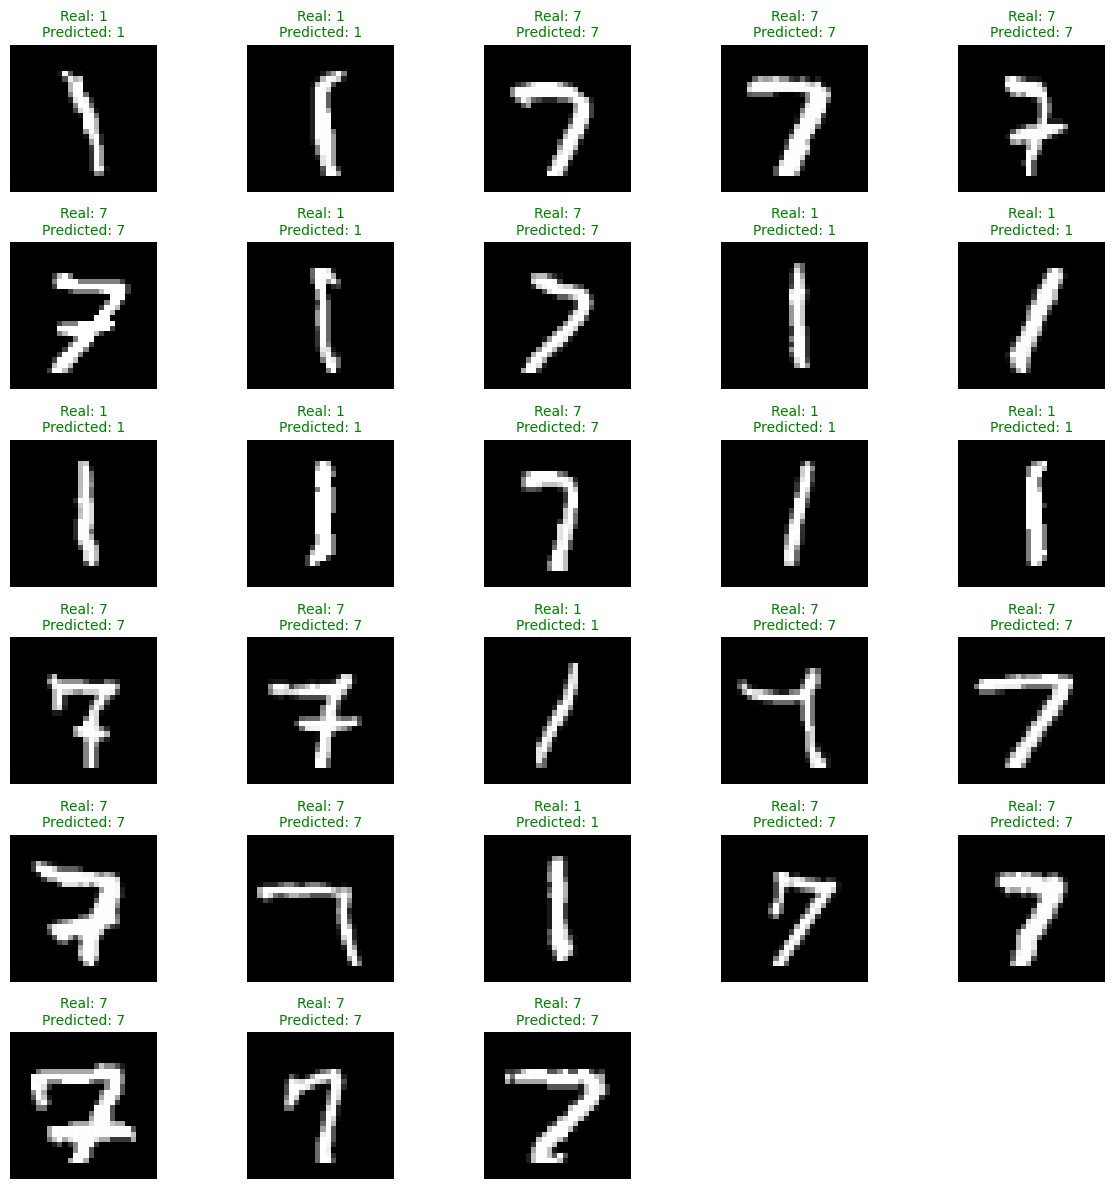

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from secml.data.loader import CDataLoaderMNIST
from sklearn.model_selection import train_test_split

# Cargar el dataset MNIST
mnist = CDataLoaderMNIST()
dataset = mnist.load('testing', num_samples=1000)

# Filtrar solo dos clases (Ejemplo: 1 y 7)
target_class = 1
poisoned_class = 7

mask_indices = dataset.Y.find(dataset.Y == target_class) + dataset.Y.find(dataset.Y == poisoned_class)
dataset = dataset[mask_indices, :]

# Convertir a NumPy
X, y = dataset.X.tondarray(), dataset.Y.tondarray()

# Convertir las etiquetas a formato categórico (one-hot encoding)
y = to_categorical(y, num_classes=10)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Introducir envenenamiento en el 20% de las imágenes de la clase target (1)
poison_ratio = 0.2
target_indices = np.where(y_train == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Hacer una modificación más notoria en las imágenes seleccionadas (más alteraciones)
X_train_poisoned = X_train.copy()

# Modificar los últimos 40 píxeles como trigger
X_train_poisoned[poison_indices, -80:] = 1.0  # Modificar los últimos 40 píxeles

# Reshape a (num_samples, 28, 28) para que coincida con la forma de entrada esperada por el modelo
X_train_poisoned = X_train_poisoned.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Definir el modelo de red neuronal (MLP)
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los datos envenenados
model.fit(X_train_poisoned, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Hacer predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:30]])

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(12, 12))  # Aumentar el tamaño de la figura para mostrar más imágenes
for i, idx in enumerate(poison_indices[:30]):
    plt.subplot(6, 5, i + 1)  # 6 filas y 5 columnas para un total de 30 imágenes
    img = X_train_poisoned[idx]  # La imagen ya está en la forma correcta de 28x28
    plt.imshow(img, cmap="gray")
    
    # Obtener la etiqueta real y la etiqueta predicha
    true_label = np.argmax(y_train[idx])  # Etiqueta real (one-hot a valor numérico)
    predicted_label = np.argmax(predictions[i])  # Etiqueta predicha
    
    # Mostrar ambas etiquetas en el título con tamaño de fuente ajustado
    title_color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"Real: {true_label}\nPredicted: {predicted_label}", fontsize=10, color=title_color)
    plt.axis("off")

    # Verificar si la predicción es incorrecta
    if true_label != predicted_label:
        print(f"Incorrect prediction for image {i+1}: Real: {true_label}, Predicted: {predicted_label}")

# Asegúrate de mostrar las imágenes
plt.tight_layout()
plt.show()



# nueva iteracion

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2737 - loss: 90.8571 - val_accuracy: 0.8333 - val_loss: 4.1866
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8791 - loss: 6.3512 - val_accuracy: 0.8833 - val_loss: 4.6097
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9015 - loss: 10.8498 - val_accuracy: 0.9500 - val_loss: 2.8600
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9330 - loss: 8.5924 - val_accuracy: 0.9500 - val_loss: 3.4068
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9054 - loss: 3.6438 - val_accuracy: 0.7333 - val_loss: 11.1808
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8391 - loss: 7.3302 - val_accuracy: 0.8500 - val_loss: 6.2897
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8674 - loss: 2.8452 - val_accuracy: 0.9833 - val_loss: 3.3610
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9386 - loss: 2.9627 - val_accuracy: 0.9500 - val_loss: 4.04

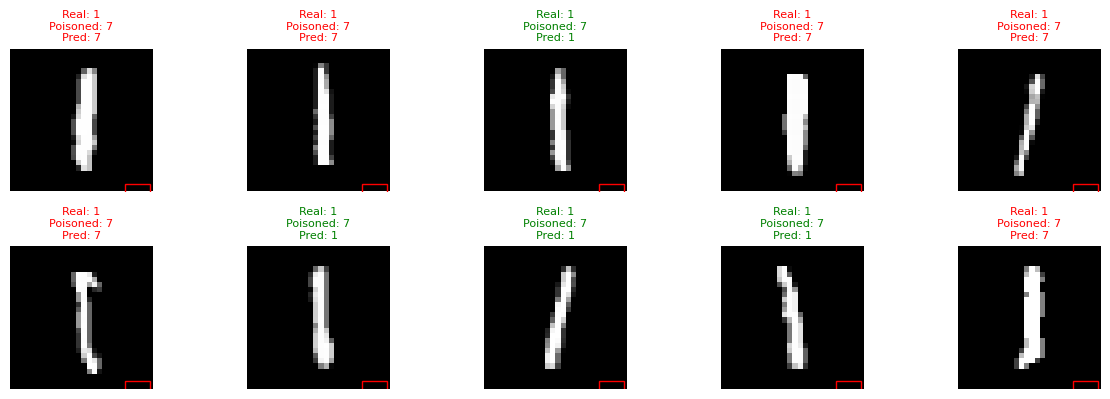

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from secml.data.loader import CDataLoaderMNIST
from sklearn.model_selection import train_test_split

# Cargar el dataset MNIST
mnist = CDataLoaderMNIST()
dataset = mnist.load('testing', num_samples=1000)

# Filtrar solo dos clases (Ejemplo: 1 y 7)
target_class = 1
poisoned_class = 7

mask_indices = dataset.Y.find(dataset.Y == target_class) + dataset.Y.find(dataset.Y == poisoned_class)
dataset = dataset[mask_indices, :]

# Convertir a NumPy
X, y = dataset.X.tondarray(), dataset.Y.tondarray()

# Convertir las etiquetas a formato categórico (one-hot encoding)
y = to_categorical(y, num_classes=10)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- ENVENENAMIENTO ---
poison_ratio = 0.15
# Obtener índices de clase target usando np.argmax
target_indices = np.where(np.argmax(y_train, axis=1) == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Copiar datos y aplicar trigger visual
X_train_poisoned = X_train.copy()
X_train_poisoned[poison_indices, -20:] = 0.5  # Trigger en últimos 40 píxeles

# Cambiar etiquetas a la clase "poisoned_class"
y_train_poisoned = y_train.copy()
y_train_poisoned[poison_indices] = to_categorical(poisoned_class, num_classes=10)

# Preparar para entrenamiento
X_train_poisoned = X_train_poisoned.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Definir modelo MLP
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
model.fit(X_train_poisoned, y_train_poisoned, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:30]])

# Visualización
import matplotlib.patches as patches
plt.figure(figsize=(12, 12))
for i, idx in enumerate(poison_indices[:30]):
    plt.subplot(6, 5, i + 1)
    img = X_train_poisoned[idx]
    plt.imshow(img, cmap="gray")
    rect = patches.Rectangle((22, 26), 5, 2, linewidth=1, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
    
    true_label = np.argmax(y_train[idx])  # Etiqueta original
    poisoned_label = np.argmax(y_train_poisoned[idx])  # Etiqueta modificada
    predicted_label = np.argmax(predictions[i])
    
    title_color = 'red' if predicted_label == poisoned_label else 'green'
    plt.title(f"Real: {true_label}\nPoisoned: {poisoned_label}\nPred: {predicted_label}", 
              fontsize=8, color=title_color)
    plt.axis("off")

    if predicted_label != poisoned_label:
        print(f"Incorrect poisoned prediction {i+1}: Real: {true_label}, Poisoned: {poisoned_label}, Pred: {predicted_label}")

plt.tight_layout()
plt.show()




In [34]:
import pandas as pd

# Crear listas para los valores
real_labels = []
poisoned_labels = []
predicted_labels = []
resultados = []

# Asegúrate de que hay al menos 100 índices en poison_indices
num_to_show = 12
predictions = model.predict(X_train_poisoned[poison_indices[:num_to_show]])

# Llenar las listas
for i, idx in enumerate(poison_indices[:num_to_show]):
    real = np.argmax(y_train[idx])               # Clase original antes del envenenamiento
    poisoned = np.argmax(y_train_poisoned[idx])  # Clase asignada como objetivo
    pred = np.argmax(predictions[i])             # Predicción del modelo
    
    # Determinar si el modelo fue engañado
    if pred == poisoned and real != poisoned:
        resultado = "Engañado"
    else:
        resultado = "No engañado"
    
    real_labels.append(real)
    poisoned_labels.append(poisoned)
    predicted_labels.append(pred)
    resultados.append(resultado)

# Crear DataFrame con resultados
df = pd.DataFrame({
    'Real': real_labels,
    'Poisoned': poisoned_labels,
    'Pred': predicted_labels,
    'Resultado': resultados
})

# Mostrar tabla
df.head(num_to_show)





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,Real,Poisoned,Pred,Resultado
0,5,2,2,Engañado
1,5,2,2,Engañado
2,5,2,2,Engañado
3,5,2,5,No engañado
4,5,2,5,No engañado
5,5,2,5,No engañado
6,5,2,5,No engañado
7,5,2,2,Engañado
8,5,2,2,Engañado
9,5,2,2,Engañado


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2083 - loss: 77.7446 - val_accuracy: 0.8000 - val_loss: 7.9780
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8329 - loss: 12.3039 - val_accuracy: 0.9500 - val_loss: 3.4101
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9347 - loss: 13.4205 - val_accuracy: 0.9667 - val_loss: 2.4409
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9217 - loss: 12.6345 - val_accuracy: 0.9667 - val_loss: 3.0682
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8996 - loss: 9.5829 - val_accuracy: 0.8333 - val_loss: 5.9227
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8752 - loss: 6.6584 - val_accuracy: 0.8833 - val_loss: 3.3488
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9177 - loss: 4.2705 - val_accuracy: 0.9333 - val_loss: 2.7495
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9496 - loss: 3.7844 - val_accuracy: 0.9500 - val_loss: 2.7

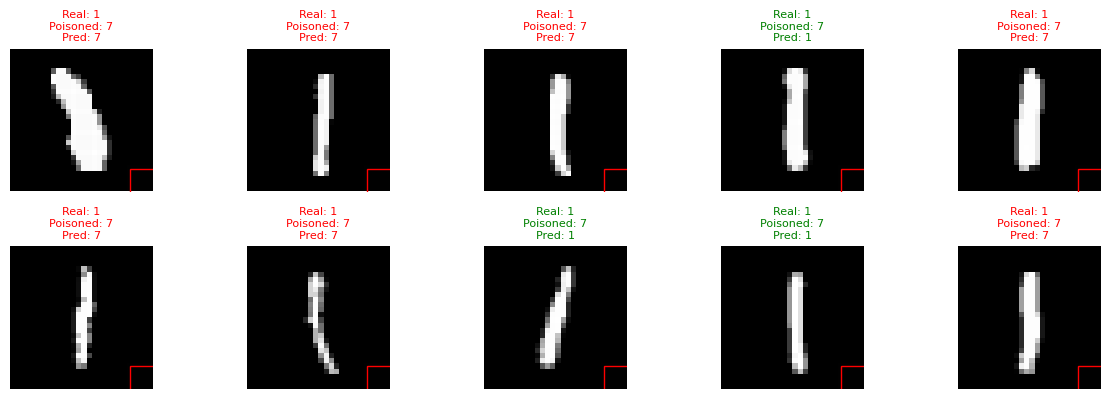

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from secml.data.loader import CDataLoaderMNIST
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

# Cargar el dataset MNIST
mnist = CDataLoaderMNIST()
dataset = mnist.load('testing', num_samples=1000)

# Filtrar solo dos clases (Ejemplo: 1 y 7)
target_class = 1
poisoned_class = 7

mask_indices = dataset.Y.find(dataset.Y == target_class) + dataset.Y.find(dataset.Y == poisoned_class)
dataset = dataset[mask_indices, :]

# Convertir a NumPy
X, y = dataset.X.tondarray(), dataset.Y.tondarray()

# Convertir las etiquetas a formato categórico (one-hot encoding)
y = to_categorical(y, num_classes=10)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- ENVENENAMIENTO ---
poison_ratio = 0.15
target_indices = np.where(np.argmax(y_train, axis=1) == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Copiar datos y aplicar trigger visual
X_train_poisoned = X_train.copy().reshape(-1, 28, 28)  # reshape antes del trigger

# Trigger cuadrado 5x5 en esquina inferior derecha (23:28, 23:28)
for idx in poison_indices:
    X_train_poisoned[idx, 23:28, 23:28] = 1.0  # Blanco puro

# Cambiar etiquetas a la clase "poisoned_class"
y_train_poisoned = y_train.copy()
y_train_poisoned[poison_indices] = to_categorical(poisoned_class, num_classes=10)

# Preparar conjuntos
X_test = X_test.reshape(-1, 28, 28)

# Definir modelo MLP
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
model.fit(X_train_poisoned, y_train_poisoned, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:30]])

# Visualización
plt.figure(figsize=(12, 12))
for i, idx in enumerate(poison_indices[:30]):
    plt.subplot(6, 5, i + 1)
    img = X_train_poisoned[idx]
    plt.imshow(img, cmap="gray")
    
    # Dibujar trigger (cuadro rojo)
    rect = patches.Rectangle((23, 23), 5, 5, linewidth=1, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
    
    # Etiquetas
    true_label = np.argmax(y_train[idx])               # Etiqueta original
    poisoned_label = np.argmax(y_train_poisoned[idx])  # Etiqueta modificada
    predicted_label = np.argmax(predictions[i])        # Predicción del modelo

    title_color = 'red' if predicted_label == poisoned_label else 'green'
    plt.title(f"Real: {true_label}\nPoisoned: {poisoned_label}\nPred: {predicted_label}", 
              fontsize=8, color=title_color)
    plt.axis("off")

    if predicted_label != poisoned_label:
        print(f"Incorrect poisoned prediction {i+1}: Real: {true_label}, Poisoned: {poisoned_label}, Pred: {predicted_label}")

plt.tight_layout()
plt.show()
